# Coherence of HD20794

### Important Note

Change the path in <tt>sys.path.insert()</tt> to wherever the NWelch source code resides on your machine.

Coherence made for RV & S-Index.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle

import sys
sys.path.insert(0, '/Users/andrewandmatthewfonseca/NWelch/src/')

import TimeSeries
import Bivariate as Bi
from scipy.stats import chi2

### Fonts and Sizes

Here we keep variables to have consistent fonts and plot sizes throughout this analysis. 

In [2]:
# Fonts and Sizes
title_font = 18
label_font = 14
text_font = 12
figsize = (9, 5)

### HD20794 Dataset

The data table for HD20794's star activity indicators reported by <a href="https://arxiv.org/abs/2501.17092v1">Nari et al. (2025)</a>.

In [3]:
data = pd.read_csv('HD20794_ESPRESSO_Nari2025.txt', delim_whitespace=True, comment='#')
data
# Excluded negative RV values, and a high Halpha value (0.220779). I also excluded outlier values for S-Index.

,JD,RV,e_RV,FWHM,e_FWHM,BisSpan,e_BisSpan,Contrast,e_Contrast,SMW,e_SMW,Ha,e_Ha,Na,e_Na,BERV
0,58721.822809,87818.159175,0.090326,5974.056716,0.180651,-59.882622,0.180651,54.543802,0.001649,0.167338,0.000011,0.202355,0.000004,0.267748,0.000003,12.749650
1,58721.824476,87817.782310,0.093716,5973.835141,0.187432,-59.453455,0.187432,54.551916,0.001712,0.166872,0.000011,0.202510,0.000005,0.267956,0.000004,12.746601
2,58721.826104,87818.804701,0.090787,5973.880441,0.181574,-59.816323,0.181574,54.547035,0.001658,0.167652,0.000011,0.202284,0.000004,0.267709,0.000003,12.743609
3,58721.827747,87818.684431,0.089394,5974.111450,0.178788,-59.486164,0.178788,54.549863,0.001633,0.167359,0.000010,0.202205,0.000004,0.268087,0.000003,12.740570
4,58721.829403,87818.987557,0.093280,5973.271262,0.186560,-59.057198,0.186560,54.551485,0.001704,0.166940,0.000011,0.202575,0.000005,0.268006,0.000004,12.737493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,60029.486014,87819.197438,0.148449,5977.835409,0.296899,-58.919196,0.296899,54.508187,0.002707,0.166376,0.000026,0.204990,0.000009,0.259514,0.000007,-6.543304
641,60029.487096,87818.501529,0.148934,5977.502660,0.297869,-58.447920,0.297869,54.520890,0.002717,0.166093,0.000027,0.204603,0.000009,0.259403,0.000007,-6.544136
642,60029.488182,87819.361491,0.150475,5978.075090,0.300949,-58.924350,0.300949,54.511588,0.002744,0.166148,0.000027,0.204725,0.000009,0.260037,0.000007,-6.544958
643,60029.489293,87818.848789,0.191174,5977.131737,0.382348,-58.477668,0.382348,54.547089,0.003489,0.165208,0.000042,0.205059,0.000013,0.259380,0.000010,-6.545786


### Stellar signals

These are variables holding the periods for a number of planets, with some being possible signals for planets. Specifically, planets c, f, and g are possible planet signals. These are found in the paper linked above.

In [4]:
# Stellar signals
pb = 18.33 # planet b
pc = 43.17 # planet c (possible)
pld = 88.90 # planet d (Changed to not conflict with pandas import)
pe = 147.02 # planet e
pf = 331.41 # planet f (possible)
pg = 11.86 # planet g (possible)

In [57]:
# Arrays for loops
planets = [1/pb, 1/pc, 1/pld, 1/pe, 1/pf, 1/pg, 1/33]
planet_labels = ['b (1/18.33)', 'c (1/43.17)', 'd (1/88.90)', 'e (1/147.02)', 'f (1/331.41)', 'g (1/11.86)', '1/33']
planet_letters = ['b', 'c', 'd', 'e', 'f', 'g', '1/33']
color_array = ['red', 'yellow', 'green', 'orange', 'purple', 'navy', 'magenta']
FAP_color_array = ['red', 'blue', 'green']

In [52]:
# Function for vertical lines
def freq_vlines():
    for p, p_l, c_a in zip(planets, planet_labels, color_array):
        plt.axvline(p, linestyle='--', color=c_a, alpha=0.7, label=p_l)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [53]:
def freq_vlines_text():
    for p, p_l, c_a in zip(planets, planet_letters, color_array):
        plt.text(p, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.05, p_l, color=c_a, fontsize=text_font, 
                 verticalalignment='bottom', horizontalalignment='center', 
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

In [59]:
def rayleigh_shading(rayleigh):
    for i in planets:
        plt.fill_between([i - rayleigh, i + rayleigh], [-7,-7], [7, 7], color='goldenrod', alpha=0.3)

<font size=10><p style="text-align:center"> RV & S-Index (Three-Segmentation) </font></p>

## RV & S-Index TimeSeries Objects

Creating TimeSeries objects and outputing various estimates of the Nyquist-like frequency, which is the highest frequency about which your data contain reliable information. The Rayleigh resolution is the lowest frequency about which your time series contains information. Prints the number of rows in the dataset, which will be used later for fake data iteration.

In [7]:
smw = TimeSeries.TimeSeries(data['JD'].to_numpy(), data['SMW'].to_numpy())
rv = TimeSeries.TimeSeries(data['JD'].to_numpy(), data['RV'].to_numpy(), display_frequency_info=False)
print("# of rows in dataset: ", smw.N)

Nyquist frequency from mean dt: 0.24624
Nyquist frequency from 10% trimmed mean dt: 2.39524
Nyquist frequency from 20% trimmed mean dt: 354.87284
Nyquist frequency from median dt: 430.63169
Rayleigh resolution: 0.00076
# of rows in dataset:  645


<Axes: xlabel='JD', ylabel='RV'>

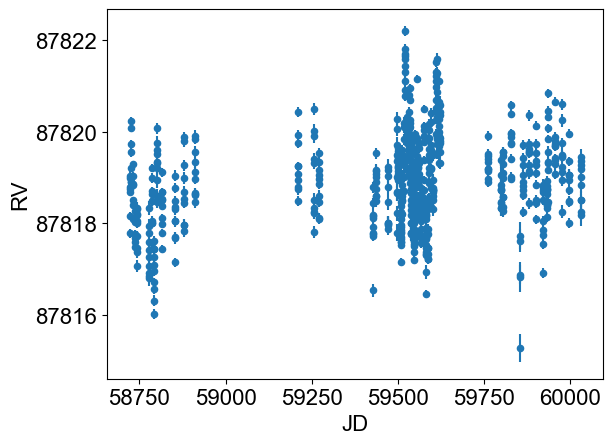

In [8]:
# Scatter plot with errorbars
# There are more points present then before; possibly more data from recent observation?)
data.plot.scatter(x='JD', y='RV', yerr='e_RV')

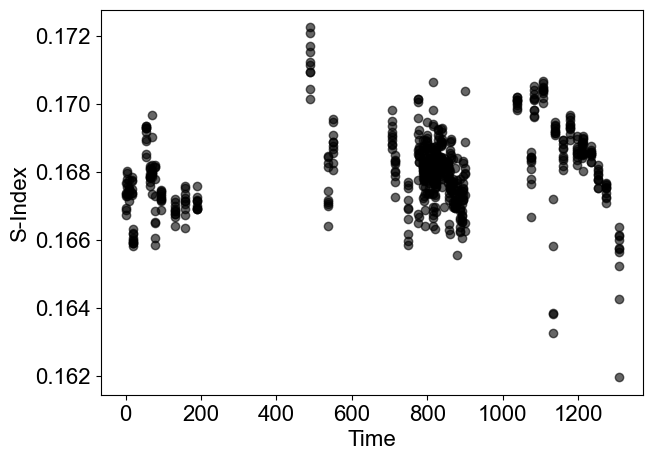

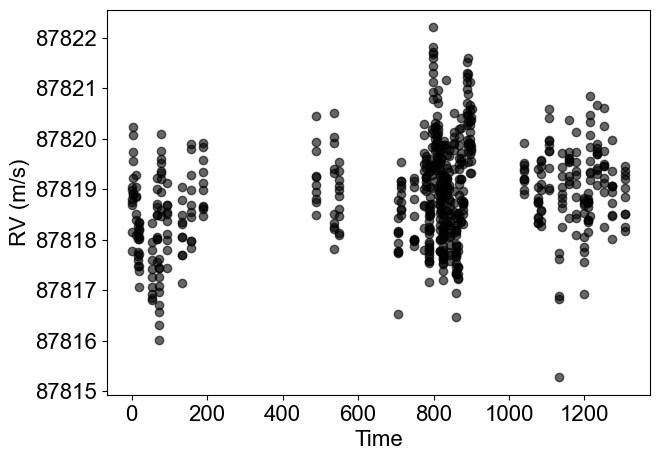

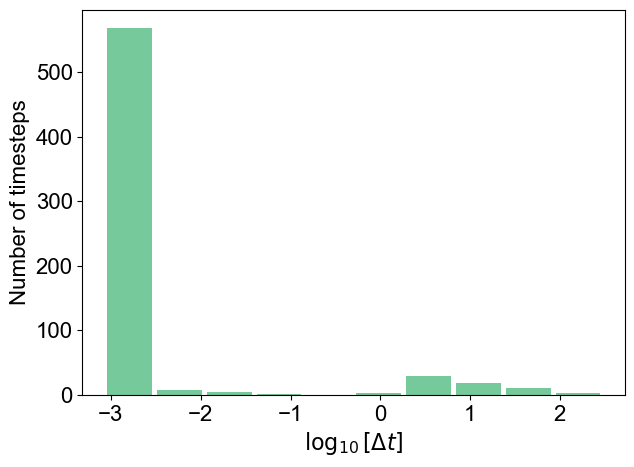

In [9]:
smw.scatterplot(ylabel="S-Index")
rv.scatterplot(ylabel="RV (m/s)")
rv.dthist()

# color/shade each part of the segmentation

In [10]:
smw.frequency_grid(0.5, 3)
rv.frequency_grid(0.5, 3)

smw.pow_FT(N_bootstrap=1000)
rv.pow_FT(N_bootstrap=1000)

Iteration 0
Iteration 500
Iteration 0
Iteration 500


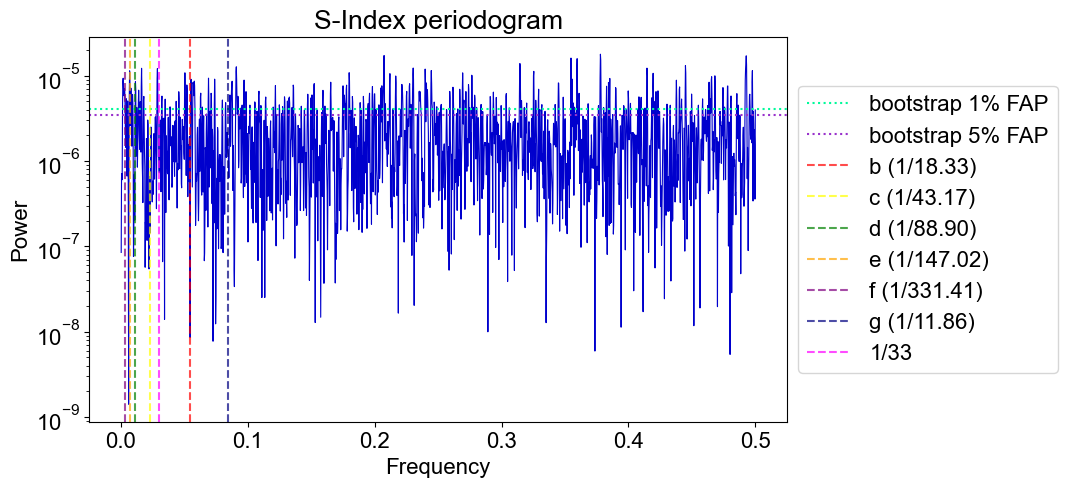

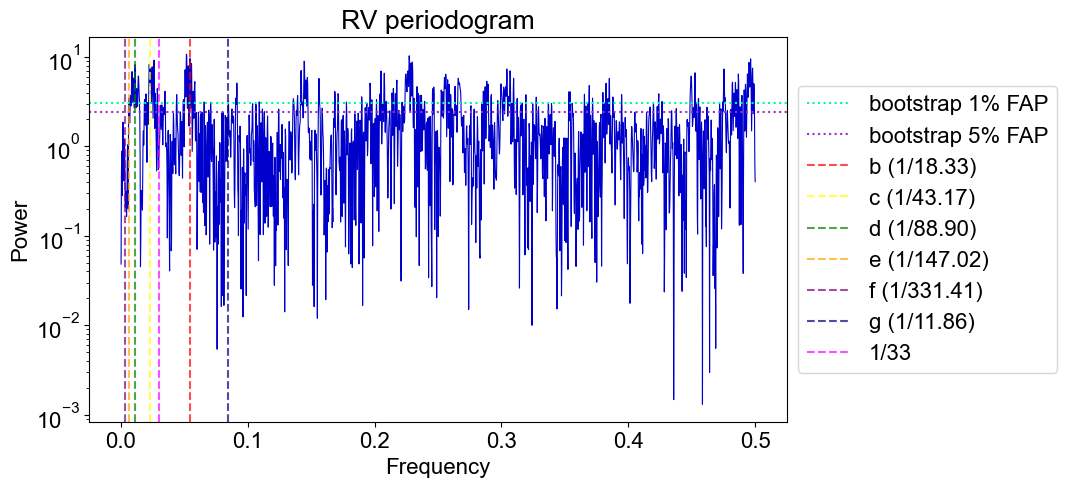

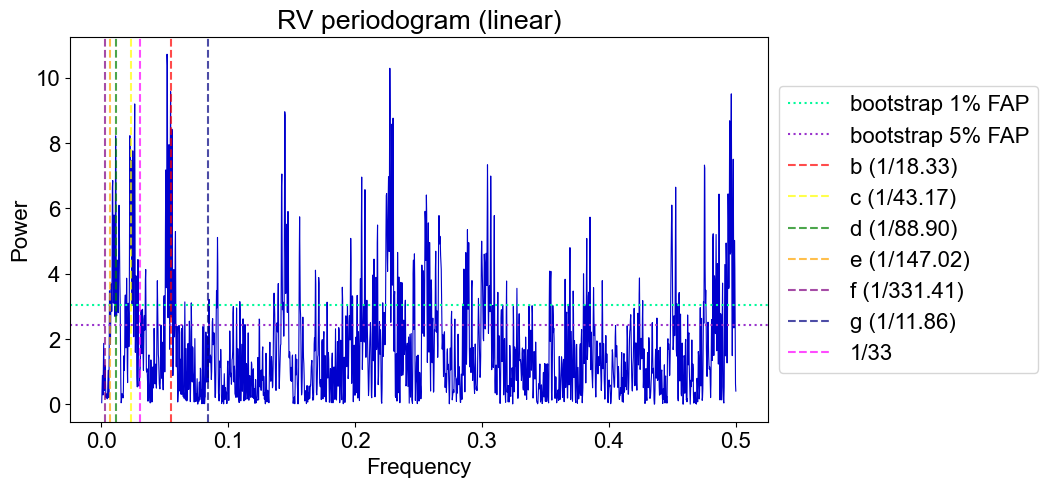

In [11]:
smw.powplot(title="S-Index periodogram")
freq_vlines()
rv.powplot(title='RV periodogram')
freq_vlines()
rv.powplot(title='RV periodogram (linear)', yscale='linear') 
freq_vlines()

In [12]:
rv.Siegel_test()
smw.Siegel_test()

T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00428
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
T statistic: 0.00135
T threshold for rejecting white noise hypothesis at 5% level: 0.00428
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


In [13]:
rv_smw = Bi.Bivariate(data['JD'].to_numpy(), data['RV'].to_numpy(), data['SMW'].to_numpy())
# create more bivariate objects for each individual segmentation array

Nyquist frequency from mean dt: 0.24624
Nyquist frequency from 10% trimmed mean dt: 2.39524
Nyquist frequency from 20% trimmed mean dt: 354.87284
Nyquist frequency from median dt: 430.63169
Rayleigh resolution: 0.00076


Number of data points per segment: 322
Number of segments: 3
Segment start and end points: [[  0 322]
 [161 483]
 [322 645]]
Effective number of segments: 2.250000
Frequency grid spacing: 0.000203
Minimum 6-dB main lobe half width: 0.001469
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003541
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001214
Number of data points per segment: 322
Number of segments: 3
Segment start and end points: [[  0 322]
 [161 483]
 [322 645]]
Effective number of segments: 2.250000
Frequency grid spacing: 0.000203
Minimum 6-dB main lobe half width: 0.001469
Mean 6-dB main lobe half width (1/2 resolution limit): 0.003541
Best achievable Rayleigh limit (1/2 best-case resolution limit): 0.001214


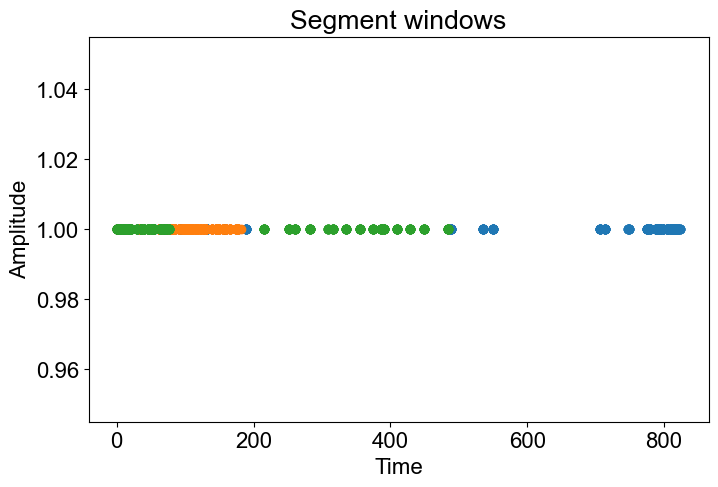

In [14]:
#rv_smw.segment_data(2, 0.2, oversample=6, window='BlackmanHarris', plot_windows=True)

rv_smw.segment_data(3, 0.2, oversample=6, plot_windows=True)

# The window is the taper, the first value is the number of segments.
# Create more instances of segmentation and tapering (2, 3, 4 segments; with and without taper).
# Create manual segment boundaries.
# continue without the taper window

In [15]:
rv_smw.Welch_coherence_powspec()
#rv_smw.Welch_coherence_powspec_bootstrap(N_coh_bootstrap=1000)
# For analytical data, the bootstrap isn't necessary, as it is useful for non-analytical data to estimate the distribution of relevant statistics.

In [16]:
rv_smw.Siegel_Welch()

Siegel's test on Sxx:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00705
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)
Siegel's test on Syy:
T statistic: 0.00000
T threshold for rejecting white noise hypothesis at 5% level: 0.00705
Null hypothesis not rejected: This time series could be white noise (or red noise; beware)


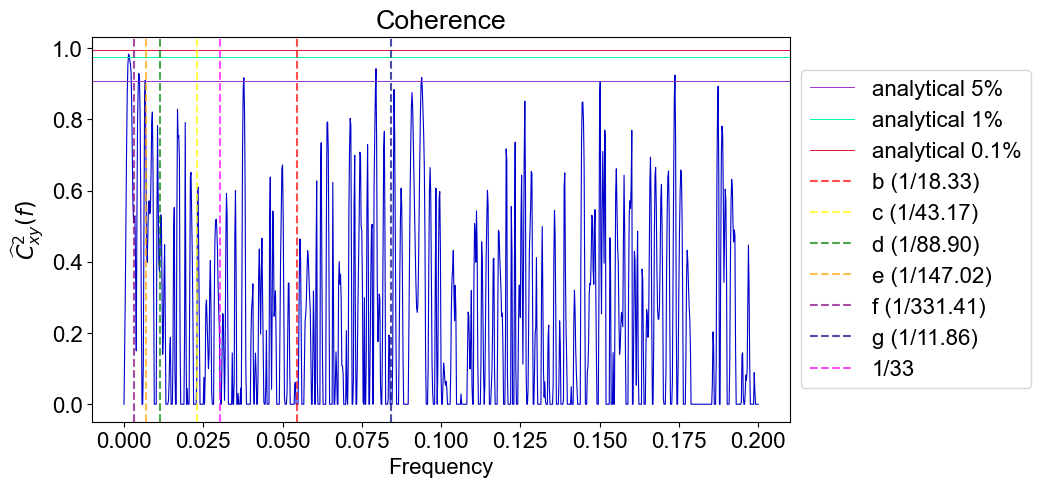

In [17]:
rv_smw.coh_plot(show_theoretical_thresholds=True)
freq_vlines()

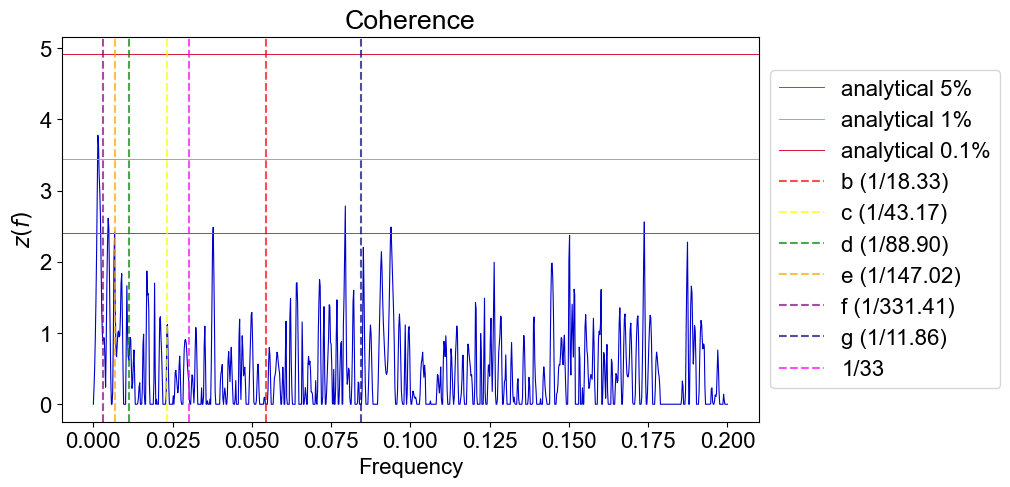

In [18]:
rv_smw.coh_plot(transformed=True, show_theoretical_thresholds=True, show_boot_thresholds=False)
freq_vlines()

Half bandwidth: 0.004268
Welch average spectral window not saved to file
Half bandwidth: 0.004268
Welch average spectral window not saved to file


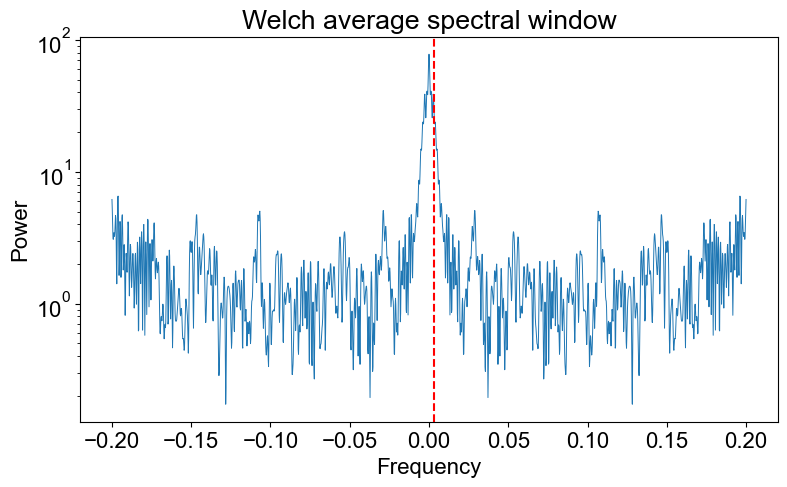

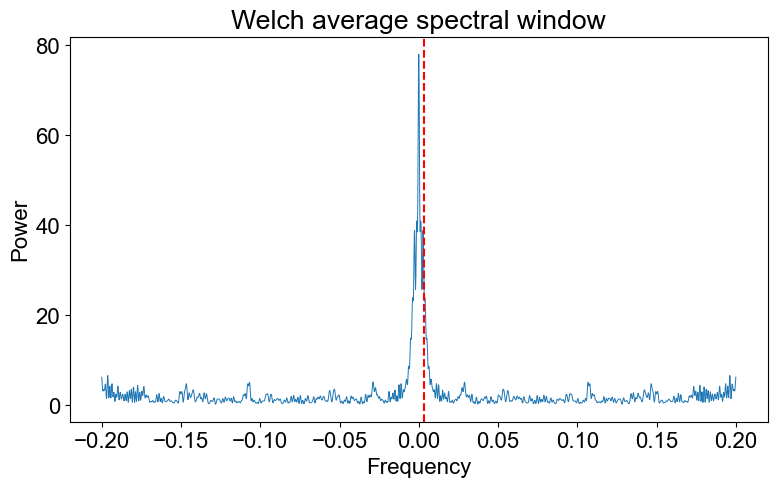

In [60]:
rv_smw.x_series.spectral_window_Welch()
plt.axvline(x=1/pf, linestyle='--', color='red')
rv_smw.x_series.spectral_window_Welch(yscale='linear')
plt.axvline(x=1/pf, linestyle='--', color='red')

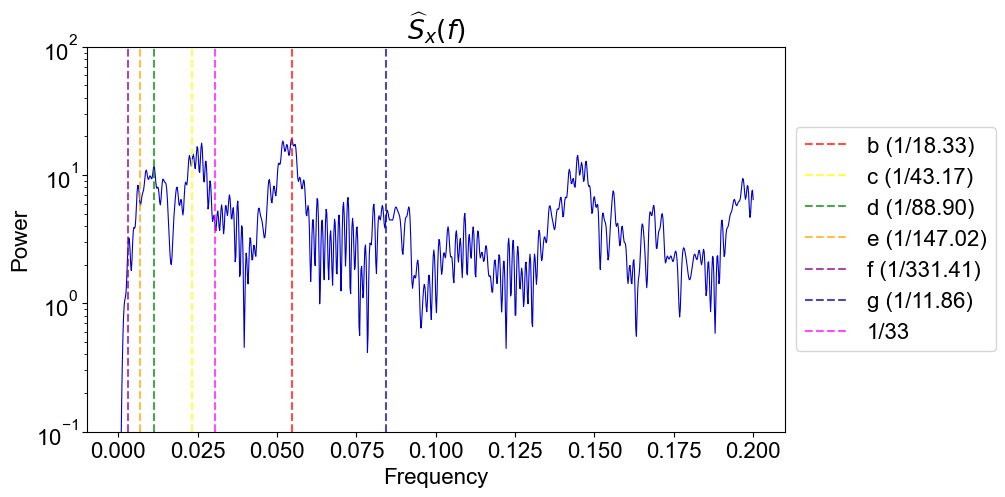

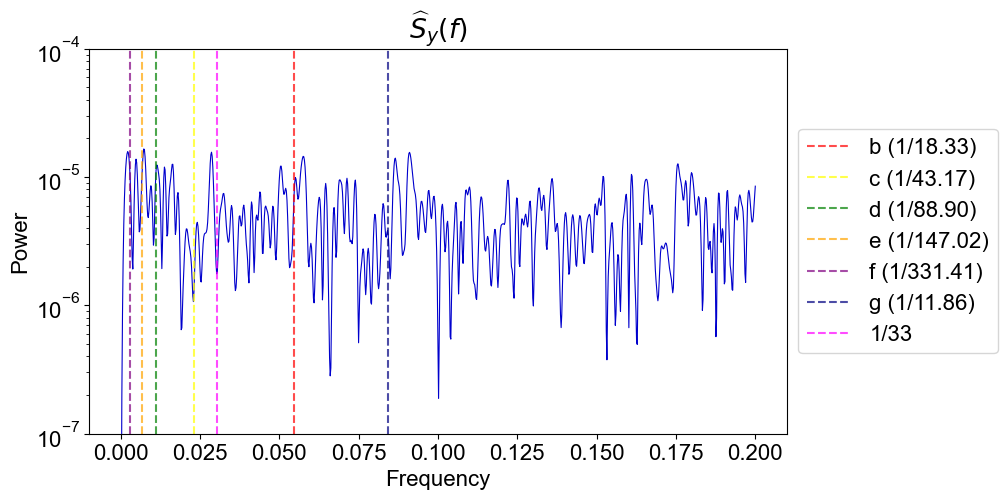

In [20]:
rv_smw.Welch_pow_plot()
plt.ylim(1e-1, 1e2)
freq_vlines()
rv_smw.Welch_pow_plot(x_or_y='y',)
plt.ylim(1e-7, 1e-4)
freq_vlines()
# Use plt.ylim to create y limit to get better looking plot

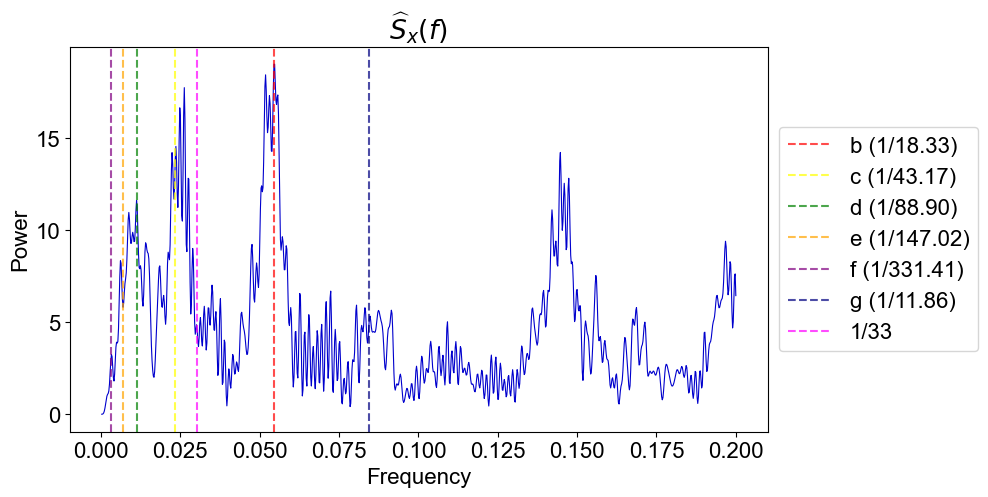

In [21]:
rv_smw.Welch_pow_plot(yscale='linear')
freq_vlines()

In [22]:
pow_smw = LombScargle(data['JD'].to_numpy(), data['SMW'].to_numpy(), normalization='psd').power(rv_smw.pow_coh_grid)
pow_rv = LombScargle(data['JD'].to_numpy(), data['RV'].to_numpy(), normalization='psd').power(rv_smw.pow_coh_grid)

In [23]:
frot_measured = rv_smw.y_series.Welch_powgrid[np.argmax(rv_smw.y_series.Welch_pow)]
print('Measured rotation period:', 1/frot_measured)

Measured rotation period: 136.66666666666706


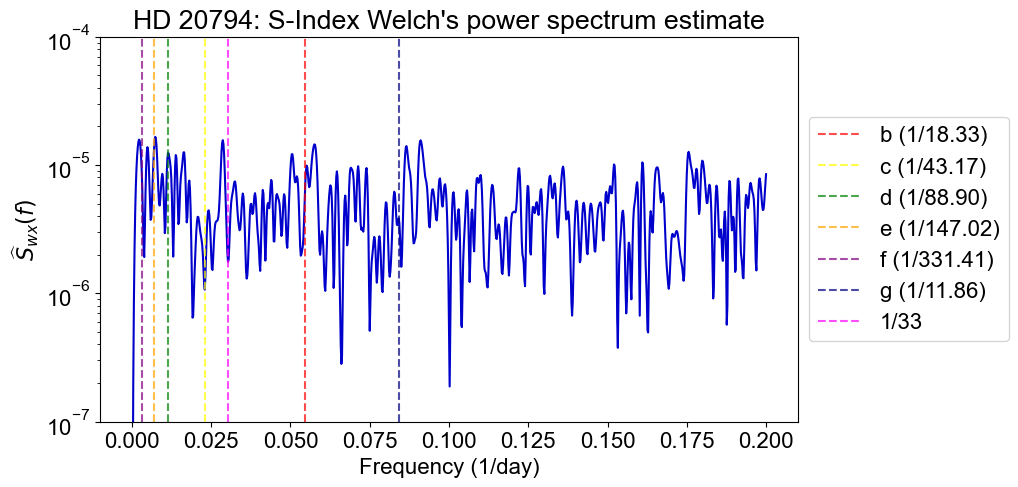

In [24]:
plt.figure(figsize=figsize)
plt.semilogy(rv_smw.pow_coh_grid, rv_smw.y_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_smw.ypow_Welch_false_alarm_01, color='crimson', ls=':', label='0.1%') # Need 10000 iteration on bootstrap; set to 1000 for now
#plt.axhline(rv_smw.ypow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_smw.ypow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

#for s in [frot_measured, 2*frot_measured]:
#    plt.axvline(s, color='k', ls='-.')
    
#for n in range(6):
#    if n == 0:
#        plt.axvline(planets[n], color='k', ls='-.', label='Planets')
#    else:
#        plt.axvline(planets[n], color='k', ls='-.')

plt.ylim(1e-7, 1e-4)
#plt.axvline(3*frot_measured, color='k', ls='-', label='meas. rotation and harmonics')
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wx}(f)$")
plt.title(r"HD 20794: S-Index Welch's power spectrum estimate")
freq_vlines()

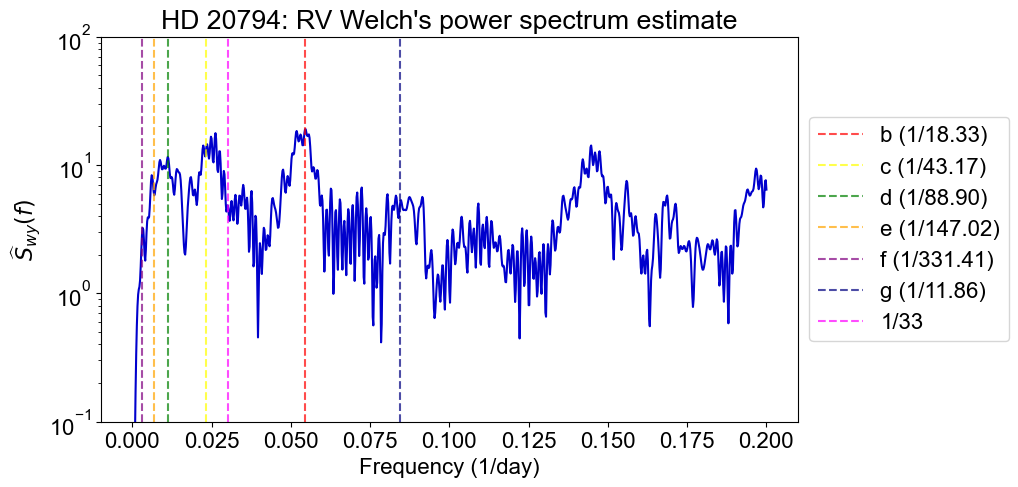

In [25]:
plt.figure(figsize=figsize)
plt.semilogy(rv_smw.pow_coh_grid, rv_smw.x_series.Welch_pow, color='mediumblue')
#plt.axhline(rv_smw.x_series.Welch_false_alarm_1 , color='crimson', ls=':', label='0.1%')
#plt.axhline(rv_smw.xpow_Welch_false_alarm_1, color='mediumspringgreen', ls=':', label='1%')
#plt.axhline(rv_smw.xpow_Welch_false_alarm_5, color='darkorchid', ls=':', label='5%')

#for n in range(6):
#    if n == 0:
#       plt.axvline(planets[n], color='k', ls='-.', label='Planets')
#    else:
#        plt.axvline(planets[n], color='k', ls='-.')
        
plt.ylim(1e-1, 1e2)
plt.xlabel('Frequency (1/day)')
plt.ylabel(r"$\widehat{S}_{wy}(f)$")
plt.title(r"HD 20794: RV Welch's power spectrum estimate")
freq_vlines()

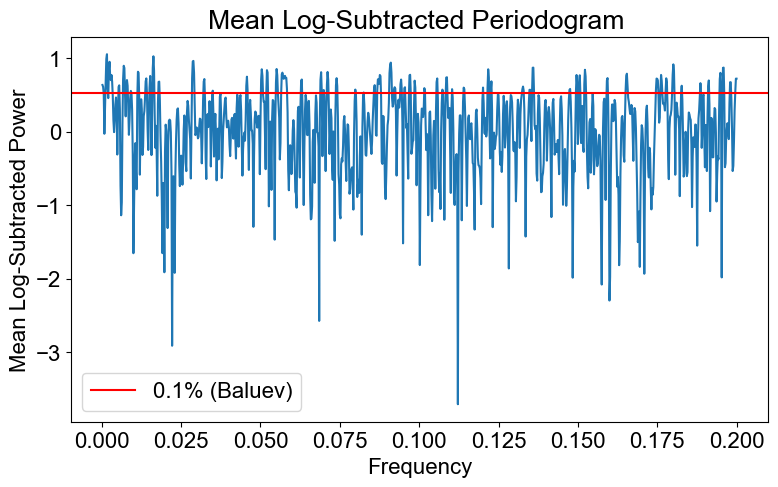

In [27]:
# Creating Mean Log-Subtracted Periodogram
ls = LombScargle(data['JD'].to_numpy(), data['SMW'].to_numpy(), normalization='psd')
power = ls.power(rv_smw.pow_coh_grid[1:])
# Clarity on using standard/default frequency grid, or the rv_smw.pow_coh_grid frequency grid. 
log_power = np.log10(power)
mean_log_power = np.mean(log_power)
log_power_subtracted = log_power - mean_log_power

false_alarm_threshold = ls.false_alarm_level(0.01, method='bootstrap')

plt.figure(figsize=figsize)
plt.plot(rv_smw.pow_coh_grid[1:], log_power_subtracted)
plt.title('Mean Log-Subtracted Periodogram ')
plt.axhline(np.log10(false_alarm_threshold) - mean_log_power, color='red', label='0.1% (Baluev)')
plt.xlabel('Frequency')
plt.ylabel('Mean Log-Subtracted Power')
plt.legend()
plt.show()

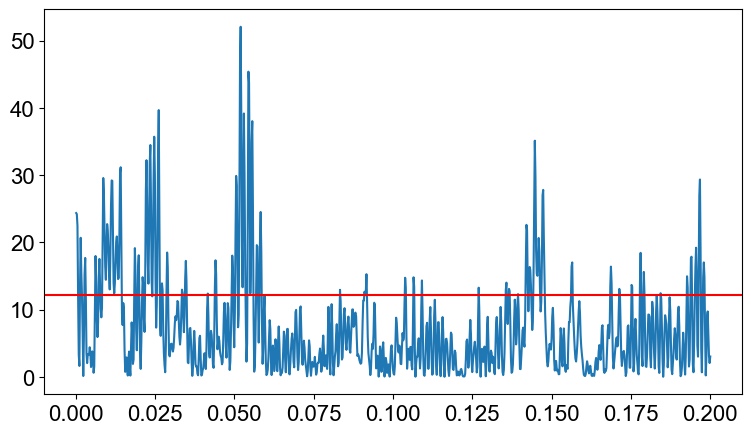

In [28]:
ls = LombScargle(data['JD'].to_numpy(), data['RV'].to_numpy(), normalization='psd')
power = ls.power(rv_smw.pow_coh_grid[1:])
plt.figure(figsize=figsize)
plt.plot(rv_smw.pow_coh_grid[1:], power)
false_alarm_threshold = ls.false_alarm_level(0.01, method='bootstrap')
plt.axhline(false_alarm_threshold, color='red', label='0.1% (Baluev)')

In [29]:
rayleigh_ls = 1/(data['JD'].to_numpy()[-1] - data['JD'].to_numpy()[0])

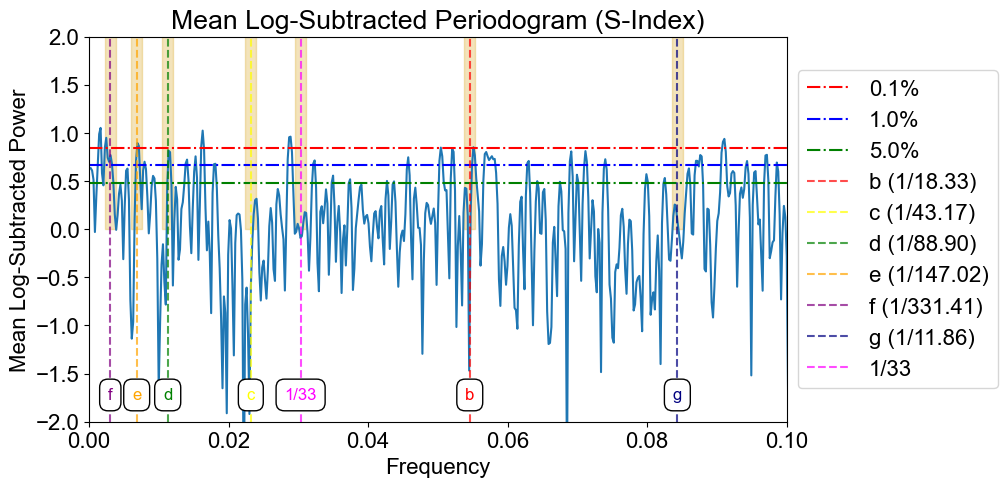

In [58]:
# Whitening (only whiten when the mean log-subtracted periodogram is not flat) (no whitening was done)
quantiles = [0.001, 0.01, 0.05]
df = 2
chi2_FALs = chi2.isf(quantiles, df) / 2
plt.figure(figsize=figsize)
plt.plot(rv_smw.pow_coh_grid[1:], log_power_subtracted)
for i, q in enumerate(chi2_FALs):
    plt.axhline(np.log10(q), color=FAP_color_array[i], label=f"{100*quantiles[i]}"+"%", ls='-.')
plt.ylim(-2,2)
plt.xlim(0,0.1)
plt.title('Mean Log-Subtracted Periodogram (S-Index)')
plt.xlabel('Frequency')
plt.ylabel('Mean Log-Subtracted Power')
rayleigh_shading(rayleigh_ls)
freq_vlines_text()
freq_vlines()
# Create a similar plot for the RVs and the rest of the activity indicators for ESPRESSO and HARPS.